In [95]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

In [96]:
import os
img_path = os.getenv('HOME')+'/mini_projects/_E-10_portrait/image/이창호7.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(447, 697, 3)


# deeplab 모델 준비

In [97]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

# 사전에 학습된 가중치를 사용해 deeplab model 초기화

In [98]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/mini_projects/_E-10_portrait/model'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel/mini_projects/_E-10_portrait/model
model loaded successfully!


# 이미지 입력

In [99]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(447, 697, 3) (328, 513, 3) 18


# 라벨 확인

In [100]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

# 이미지에서 사람만 추출

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


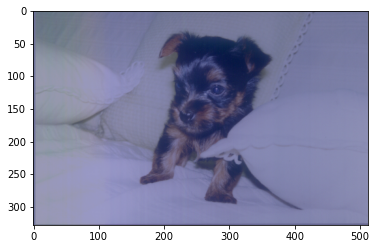

In [101]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 이미지 크기 복원

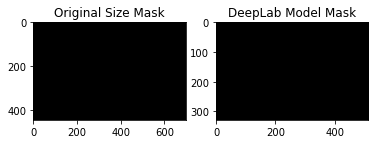

In [103]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# 배경 추출

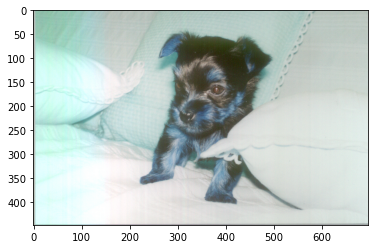

In [104]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

# 블러 처리

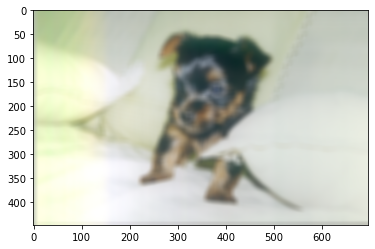

In [105]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 이미지 합성

<function matplotlib.pyplot.show(close=None, block=None)>

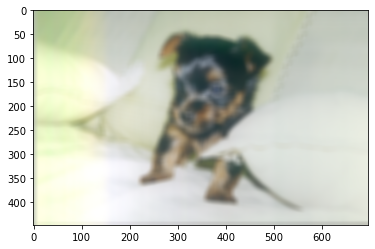

In [106]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat,cv2.COLOR_BGR2RGB))
plt.show

# openCV BGR 객체 RGB로 변환 후 파일로 저장

In [107]:
img = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

In [108]:

plt.imsave('6.png',img)

In [109]:
# from PIL import Image    # 이미지 저장하는 또 다른 방법

# img = Image.fromarray(img_concat)
# if img.mode != 'RGB':
#    img = img.convert('RGB')
# img.save('1.jpg')

# 노드에서 제시된 코드만으로 만들었을 때 사진들의 문제점

![1](https://blog.kakaocdn.net/dn/mPsRg/btqXN9lmZvq/CZVQAtyNLzP9EkCl6kpCYk/img.png)

1. 인물과 배경의 경계가 깔끔하지 않다.   
2. 오른쪽 무릎 아래 가방은 블러처리가 되지 않았고, 왼쪽 신발은 일부분 블러 처리가 되었다.

![2](https://blog.kakaocdn.net/dn/X4uIz/btqXFfgrZ6l/vTMBHGiLDpzvajSqvKnOuK/img.png)

1. 식탁 위에 손을 올려 놓은 경우 제대로 세그멘테이션 되지 않는다   

![3](https://blog.kakaocdn.net/dn/bhRWMR/btqXHgeZxJ9/8Cs7cHeaKhmtt5zz04FWAk/img.png)

1. 검은색 가방이 반복해서 인물과 함께 추출된다. 왜지?

![4](https://blog.kakaocdn.net/dn/bpjs9G/btqXOakefwn/4nPCVElJuPSMFGJPnSILj1/img.png)

1. 배경에 인물이 있을 경우 무조건 잡힌다   
2. 손에 무언갈 쥐고 있을 경우 손이라고 인식되지 않으면 배경처리 되는 것 같다. 

![4](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FEuOUf%2FbtqXLegnInB%2F6Q8Rrl4RK4oCXOn8FJKjE0%2Fimg.png)

1. 멀리 있는 인물뿐만 아니라 가까이 있는 인물도 배경처리가 되지 않는다

![6](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlF6K3%2FbtqXHfmTZZR%2FpLwwGeY0KyNQUsqwbOJgKk%2Fimg.png)

동물은 배경처리된다.

# 개선방법   
   
## Encoder / Decoder 구조   
   
encoder 에서 이미지 크기를 줄여가며 feature를 뽑아내고   
decoder 에서 다시 upconvolution으로 이미지 축소로 인해 손실된 정보를 복원한다고 하는데   
이 부분이 정교한 boundary 형성을 가능하게 한다고 하나 이걸 어떻게 내가 건드릴 수 있는진 모르겠다   

# 회고

잘 모르겠다. 사진을 싫어해서 그런지 shallow focus가 딱히 대단한 기술인지, 좋은 기술인지도 모르곘다.   
이게 어떻게 작동하는 건지, 개선점이 뭔지 별로 궁금하지가 않다.   
여기에 쏟을 시간을 다른 거 공부하는 데 쓰고 싶다.